In [1]:
from langgraph.graph import StateGraph,START,END
from typing import TypedDict
from dotenv import load_dotenv
from langchain_huggingface import ChatHuggingFace, HuggingFaceEndpoint
from langchain_google_genai import ChatGoogleGenerativeAI
from typing import Literal

In [2]:
!pip install langchain-google-genai


[notice] A new release of pip is available: 24.2 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [4]:
from models import Classification,Response
from langchain_core.output_parsers import PydanticOutputParser
from langchain_core.prompts import PromptTemplate


In [5]:
load_dotenv()

True

In [6]:
# llm = HuggingFaceEndpoint(
#     repo_id="google/gemma-2-2b-it",
#     task="text-generation"
#     )
# model = ChatHuggingFace(llm=llm)

In [7]:
model = ChatGoogleGenerativeAI(model='gemini-2.5-pro', convert_system_message_to_human=True)

In [8]:
class Attribute(TypedDict):
    class_: str
    reason: str
class AttributesState(TypedDict):
    query: str
    category: str
    classification: list

In [9]:
def query_classification(state: AttributesState):
    query = state['query']

    # Output parser
    parser = PydanticOutputParser(pydantic_object=Classification)

    # Prompt template
    template = PromptTemplate(
        template=(
            "You are an expert in genetic variant interpretation.\n"
            "Based on the following query, classify the variant according to ACMG/AMP guidelines.\n\n"
            "Respond ONLY in the following format:\n"
            "{format_instructions}\n\n"
            "Query: {query}"
        ),
        input_variables=['query'],
        partial_variables={'format_instructions': parser.get_format_instructions()}
    )

    # Chain together
    chain = template | model | parser

    # Run chain
    final_result = chain.invoke({'query': query})

    state['category'] = final_result.model_dump()['class_']
    # state['category']=final_result['class_']
    return state

In [10]:
def pathogenic_classification(state: AttributesState):
    query= state['query']
    parser = PydanticOutputParser(pydantic_object=Response)
    template = PromptTemplate(
        template = (
            "You are a Expert in Genetic variant interpretation. \n"
            "Based on the following query, classify the variant according to ACMG/AMP guidelines in the following creteria : PVS1 – Very Strong , PS1 – Strong , PS2 – Strong , PS3 – Strong , PS4 – Strong , PM1 – Moderate , PM2 – Moderate , PM3 – Moderate , PM4 – Moderate , PM5 – Moderate , PM6 – Moderate , PP1 – Supporting , PP2 – Supporting , PP3 – Supporting , PP4 – Supporting , PP5 – Supporting (Deprecated). and also give the reason.\n\n"
            "Respond ONLY in the following format:\n"
            "{format_instructions}\n\n"
            "Query: {query}"
        ),
        input_variables=['query'],
        partial_variables={'format_instructions': parser.get_format_instructions()}
    )
    chain = template | model | parser

    # Run chain
    final_result = chain.invoke({'query': query})

    return {'classification':final_result.model_dump()['result']}


In [11]:
def benign_classification(state: AttributesState):
    query= state['query']
    parser = PydanticOutputParser(pydantic_object=Response)
    template = PromptTemplate(
        template = (
            "You are a Expert in Genetic variant interpretation. \n"
            "Based on the following query, classify the variant according to ACMG/AMP guidelines in the following creteria "
            "BA1 (Stand-alone) , BS1 (Strong) , BS2 (Strong) , BS3 (Strong) , BS4 (Strong) , \nBP1–BP7 (Supporting) \nBP1: Missense in a gene where only truncating variants cause disease."
            "\nBP2: Observed in trans with a pathogenic variant (dominant disorder).\nBP3: In-frame indels in non-conserved regions.\nBP4: Multiple tools predict benign.\nBP5: Variant found in individual with alternate cause of disease.\nBP6: Reputable source reports benign without supporting data.\nBP7: Synonymous variant with no predicted splicing effect.. and also give the reason.\n\n"
            "Respond ONLY in the following format:\n"
            "{format_instructions}\n\n"
            "Query: {query}"
        ),
        input_variables=['query'],
        partial_variables={'format_instructions': parser.get_format_instructions()}
    )
    chain = template | model | parser

    # Run chain
    final_result = chain.invoke({'query': query})


    return {'classification':final_result.model_dump()['result']}


In [12]:
def not_valid_classification(state: AttributesState):
    return {'classification':[]}


In [13]:
def category_classification(state: AttributesState) -> Literal["pathogenic_classification", "benign_classification","not_valid_classification"]:
    if state['category'] == "Pathogenic":
        return 'pathogenic_classification'
    elif state['category'] == "Benign":
        return 'benign_classification'
    else:
        return 'not_valid_classification'


In [14]:
graph = StateGraph(AttributesState)

graph.add_node('query_classification',query_classification)
graph.add_node('pathogenic_classification',pathogenic_classification)
graph.add_node('benign_classification',benign_classification)
graph.add_node('not_valid_classification',not_valid_classification)

graph.add_edge(START,'query_classification')
graph.add_conditional_edges('query_classification',category_classification)
graph.add_edge('pathogenic_classification',END)
graph.add_edge('benign_classification',END)

workflow = graph.compile()

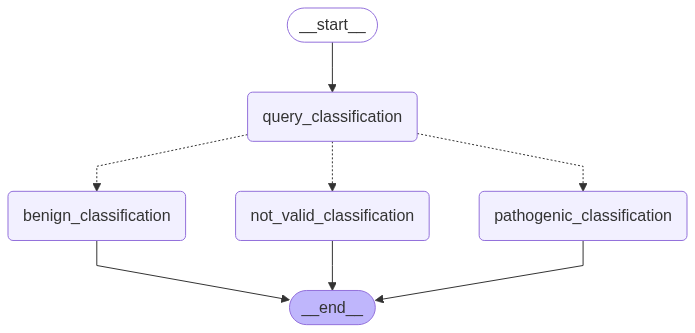

In [15]:
workflow

In [19]:
workflow.invoke({'query':'The p.A2603T variant (also known as c.7807G>A), located in coding exon 16 of the BRCA2 gene, results from a G to A substitution at nucleotide position 7807. The alanine at codon 2603 is replaced by threonine, an amino acid with similar properties. This alteration was functional in a drug sensitivity assay (Ikegami M et al. Nat Commun, 2020 05;11:2573). This amino acid position is highly conserved in available vertebrate species. In addition, this alteration is predicted to be deleterious by in silico analysis. Since supporting evidence is limited at this time, the clinical significance of this alteration remains unclear.'})

c:\Users\rishi\Desktop\Personal\Testing\venv\Lib\site-packages\langchain_google_genai\chat_models.py:483: UserWarning: Convert_system_message_to_human will be deprecated!
  warnings.warn("Convert_system_message_to_human will be deprecated!")


{'query': 'The p.A2603T variant (also known as c.7807G>A), located in coding exon 16 of the BRCA2 gene, results from a G to A substitution at nucleotide position 7807. The alanine at codon 2603 is replaced by threonine, an amino acid with similar properties. This alteration was functional in a drug sensitivity assay (Ikegami M et al. Nat Commun, 2020 05;11:2573). This amino acid position is highly conserved in available vertebrate species. In addition, this alteration is predicted to be deleterious by in silico analysis. Since supporting evidence is limited at this time, the clinical significance of this alteration remains unclear.',
 'category': 'N/A',
 'classification': []}

In [21]:
!pip install pandas

   ---------------------------------------- 0.0/11.0 MB ? eta -:--:--
   --- ------------------------------------ 1.0/11.0 MB 6.3 MB/s eta 0:00:02
   ------ --------------------------------- 1.8/11.0 MB 4.8 MB/s eta 0:00:02
   -------- ------------------------------- 2.4/11.0 MB 3.9 MB/s eta 0:00:03
   ------------- -------------------------- 3.7/11.0 MB 4.2 MB/s eta 0:00:02
   ---------------- ----------------------- 4.5/11.0 MB 4.1 MB/s eta 0:00:02
   ------------------- -------------------- 5.2/11.0 MB 4.1 MB/s eta 0:00:02
   --------------------- ------------------ 6.0/11.0 MB 4.1 MB/s eta 0:00:02
   ------------------------ --------------- 6.8/11.0 MB 4.1 MB/s eta 0:00:02
   --------------------------- ------------ 7.6/11.0 MB 4.1 MB/s eta 0:00:01
   ------------------------------ --------- 8.4/11.0 MB 4.0 MB/s eta 0:00:01
   --------------------------------- ------ 9.2/11.0 MB 4.0 MB/s eta 0:00:01
   ------------------------------------- -- 10.2/11.0 MB 4.0 MB/s eta 0:00:01
   --


[notice] A new release of pip is available: 24.2 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [96]:
import pandas as pd
import numpy as np

In [102]:
 df = pd.read_excel(r"C:\Users\rishi\Downloads\clinvar_sentences_annotated_ambrey_genetics_v21 1 (1).xlsx")

In [103]:
df

,global_index,Length,SCV,Description,Sentences,ACMG_Codes,Keywords_inclusion,Keywords_exclusion,Remarks,Corrected_Attribute,Validated
0,35421,17,SCV001170543.3,Other strong data,Other strong data,['unknown'],NaN,NaN,NaN,NaN,NaN
1,102577,20,SCV005020087.1,Elaine has saved RD.,Elaine has saved RD.,['unknown'],NaN,NaN,NaN,NaN,NaN
2,264484,31,SCV002672085.2,The c.737_739delTAG variant (also known as p.V...,Valine at codon 246 is deleted.,['unknown'],NaN,NaN,NaN,NaN,NaN
3,5414,33,SCV005022010.1,ASSESSED FOR SOMATIC SAMPLE ONLY. FOR ANY GERM...,ASSESSED FOR SOMATIC SAMPLE ONLY.,['unknown'],NaN,NaN,NaN,NaN,NaN
4,22765,35,SCV002722155.3,The p.P654L pathogenic mutation (also known as...,Similar results were seen in yeast.,['unknown'],NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
14061,10403,579,SCV002607110.3,The c.3347-1G>A intronic variant results from ...,"In addition, this alteration has been detected...",['unknown'],NaN,NaN,NaN,NaN,NaN
14062,13339,580,SCV000262906.8,The c.815-27T>C intronic alteration consists o...,Functional analysis of cultured fibroblasts fr...,['unknown'],NaN,NaN,NaN,NaN,NaN
14063,226256,589,SCV003602117.2,The c.2638C>T (p.R880C) alteration is located ...,This alteration was reported de novo in an ind...,['PS2'],NaN,NaN,NaN,NaN,NaN
14064,26904,597,SCV000666873.6,"The p.S382I variant (also known as c.1145G>T),...","Across multiple studies, this alteration has b...",['unknown'],NaN,NaN,NaN,NaN,NaN


In [112]:
temp=df[~(df['Corrected_Attribute'].isna())]

In [113]:
temp['Corrected_Attribute'].value_counts()

Corrected_Attribute
Unknown            156
BS3                 46
PS1 (automated)     14
PS2                 14
PS3                 13
PM3                  8
BP2                  4
PM6                  4
['BS3']              3
PP1                  3
PS1                  2
Unkknown             1
Unkown               1
PS3 + BS3            1
PM3.                 1
BP2, BS3             1
PP1, PM3             1
BS3, PP1             1
PS4                  1
PS1 or PM5           1
PM3, PS4             1
PS4, PP1             1
Name: count, dtype: int64

In [108]:
temp=temp[~(temp['ACMG_Codes']=="['unknown']")]

In [31]:
prompt_gen_data = df[~(df['Corrected_Attribute'].isna())]

In [109]:
temp['Corrected_Attribute']

228              Unknown
233              ['BS3']
249                  PM6
283              Unknown
336              Unknown
              ...       
13961    PS1 (automated)
13983    PS1 (automated)
14026            Unknown
14045    PS1 (automated)
14060            Unknown
Name: Corrected_Attribute, Length: 278, dtype: object

In [121]:
temp.loc[temp['Corrected_Attribute']=='Unknown', 'Corrected_Attribute'] = temp.loc[temp['Corrected_Attribute']=='Unknown', 'ACMG_Codes']


In [122]:
temp.Corrected_Attribute.value_counts()

Corrected_Attribute
['PS3']            81
BS3                46
['PP1']            19
['BP2']            17
['PS4']            16
PS2                14
PS1 (automated)    14
PS3                13
['BS3']             8
PM3                 8
['BP2', 'PS3']      5
PM6                 4
BP2                 4
['BP2', 'PP1']      3
PP1                 3
['PS2']             2
PS1                 2
['PP4']             1
BS3, PP1            1
['PM3', 'PP1']      1
PM3, PS4            1
PS1 or PM5          1
PS4                 1
['BS4']             1
['PS2', 'PP1']      1
['PS3', 'PP1']      1
['BP2', 'PS4']      1
['PS2', 'PS3']      1
PM3.                1
PP1, PM3            1
BP2, BS3            1
Unkown              1
Unkknown            1
PS3 + BS3           1
['PP1', 'PP4']      1
PS4, PP1            1
Name: count, dtype: int64

In [123]:
temp

,global_index,Length,SCV,Description,Sentences,ACMG_Codes,Keywords_inclusion,Keywords_exclusion,Remarks,Corrected_Attribute,Validated,class
228,7251,59,SCV000244120.7,"The c.1147dupC (p.H383Pfs*103) alteration, loc...",Frameshift alterations are typically deleterio...,['PS3'],NaN,alterations are typically,Clear experimental evidence for effect on prot...,['PS3'],Yes,N/A
233,38949,59,SCV002669159.2,The p.A2603T variant (also known as c.7807G>A)...,This alteration was functional in a drug sensi...,['PS3'],was functional,NaN,NaN,['BS3'],Yes,Benign
249,66057,60,SCV002657226.2,"The p.L21P variant (also known as c.62T>C), lo...",It is reported that 56-70% of mutations in JAG...,['PS2'],NaN,NaN,The specific variant is denovo or not?,PM6,Yes,Pathogenic
283,1171200,61,SCV005477809.1,The c.125-9831_236del9943 gross deletion inclu...,"However, gross deletions are typically deleter...",['PS3'],NaN,NaN,Clear experimental evidence for effect on prot...,['PS3'],Yes,N/A
336,9670,64,SCV000186344.10,The p.M3118T variant (also known as c.9353T>C)...,This alteration was reported in a Japanese bre...,['PP1'],NaN,NaN,segregation among Multiple affected family mem...,['PP1'],Yes,N/A
...,...,...,...,...,...,...,...,...,...,...,...,...
13961,98531,387,SCV000580060.6,The c.1212A>C variant (also known as p.*404CEX...,"In one study, a different but similar alterati...",['PS2'],NaN,", a different but similar alteration, c.1211G>C,",Not regarding the same variant,PS1 (automated),Yes,Pathogenic
13983,103485,396,SCV000741280.4,The c.1921A>G (p.N641D) alteration is located ...,A de novo GRIN1 c.1950C>G (p.N650K) alteration...,['PS2'],NaN,NaN,Not regarding the same variant,PS1 (automated),Yes,Pathogenic
14026,24783,437,SCV000215935.8,"The c.862_863delCA pathogenic mutation, locate...",This alteration has been reported in an indivi...,"['BP2', 'PS3']",NaN,NaN,BP2 evidence not clear as variant is predicted...,"['BP2', 'PS3']",Yes,N/A
14045,131638,464,SCV000737005.5,"The p.L622R variant (also known as c.1865T>G),...",An alternate substitution at this position p.L...,['PS2'],NaN,An alternate substitution at this position,Not regarding the same variant,PS1 (automated),Yes,Pathogenic


In [124]:
def classification(x):
    x=str(x)
    if ('B' in x) and ('P' in x):
        return 'Both'
    elif ('B' in x):
        return 'Benign'
    elif ('P' in x):
        return 'Pathogenic'
    else:
        return 'N/A'

In [125]:
temp['class']=temp['Corrected_Attribute'].apply(classification)

C:\Users\rishi\AppData\Local\Temp\ipykernel_21284\1372679072.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp['class']=temp['Corrected_Attribute'].apply(classification)


In [126]:
temp

,global_index,Length,SCV,Description,Sentences,ACMG_Codes,Keywords_inclusion,Keywords_exclusion,Remarks,Corrected_Attribute,Validated,class
228,7251,59,SCV000244120.7,"The c.1147dupC (p.H383Pfs*103) alteration, loc...",Frameshift alterations are typically deleterio...,['PS3'],NaN,alterations are typically,Clear experimental evidence for effect on prot...,['PS3'],Yes,Pathogenic
233,38949,59,SCV002669159.2,The p.A2603T variant (also known as c.7807G>A)...,This alteration was functional in a drug sensi...,['PS3'],was functional,NaN,NaN,['BS3'],Yes,Benign
249,66057,60,SCV002657226.2,"The p.L21P variant (also known as c.62T>C), lo...",It is reported that 56-70% of mutations in JAG...,['PS2'],NaN,NaN,The specific variant is denovo or not?,PM6,Yes,Pathogenic
283,1171200,61,SCV005477809.1,The c.125-9831_236del9943 gross deletion inclu...,"However, gross deletions are typically deleter...",['PS3'],NaN,NaN,Clear experimental evidence for effect on prot...,['PS3'],Yes,Pathogenic
336,9670,64,SCV000186344.10,The p.M3118T variant (also known as c.9353T>C)...,This alteration was reported in a Japanese bre...,['PP1'],NaN,NaN,segregation among Multiple affected family mem...,['PP1'],Yes,Pathogenic
...,...,...,...,...,...,...,...,...,...,...,...,...
13961,98531,387,SCV000580060.6,The c.1212A>C variant (also known as p.*404CEX...,"In one study, a different but similar alterati...",['PS2'],NaN,", a different but similar alteration, c.1211G>C,",Not regarding the same variant,PS1 (automated),Yes,Pathogenic
13983,103485,396,SCV000741280.4,The c.1921A>G (p.N641D) alteration is located ...,A de novo GRIN1 c.1950C>G (p.N650K) alteration...,['PS2'],NaN,NaN,Not regarding the same variant,PS1 (automated),Yes,Pathogenic
14026,24783,437,SCV000215935.8,"The c.862_863delCA pathogenic mutation, locate...",This alteration has been reported in an indivi...,"['BP2', 'PS3']",NaN,NaN,BP2 evidence not clear as variant is predicted...,"['BP2', 'PS3']",Yes,Both
14045,131638,464,SCV000737005.5,"The p.L622R variant (also known as c.1865T>G),...",An alternate substitution at this position p.L...,['PS2'],NaN,An alternate substitution at this position,Not regarding the same variant,PS1 (automated),Yes,Pathogenic


In [127]:
cleaned=temp[temp['Corrected_Attribute']!="['unknown']"]

In [128]:
cleaned.loc[:,['Description','Corrected_Attribute','class']].to_csv('final_classification.csv')

In [129]:
cleaned

,global_index,Length,SCV,Description,Sentences,ACMG_Codes,Keywords_inclusion,Keywords_exclusion,Remarks,Corrected_Attribute,Validated,class
228,7251,59,SCV000244120.7,"The c.1147dupC (p.H383Pfs*103) alteration, loc...",Frameshift alterations are typically deleterio...,['PS3'],NaN,alterations are typically,Clear experimental evidence for effect on prot...,['PS3'],Yes,Pathogenic
233,38949,59,SCV002669159.2,The p.A2603T variant (also known as c.7807G>A)...,This alteration was functional in a drug sensi...,['PS3'],was functional,NaN,NaN,['BS3'],Yes,Benign
249,66057,60,SCV002657226.2,"The p.L21P variant (also known as c.62T>C), lo...",It is reported that 56-70% of mutations in JAG...,['PS2'],NaN,NaN,The specific variant is denovo or not?,PM6,Yes,Pathogenic
283,1171200,61,SCV005477809.1,The c.125-9831_236del9943 gross deletion inclu...,"However, gross deletions are typically deleter...",['PS3'],NaN,NaN,Clear experimental evidence for effect on prot...,['PS3'],Yes,Pathogenic
336,9670,64,SCV000186344.10,The p.M3118T variant (also known as c.9353T>C)...,This alteration was reported in a Japanese bre...,['PP1'],NaN,NaN,segregation among Multiple affected family mem...,['PP1'],Yes,Pathogenic
...,...,...,...,...,...,...,...,...,...,...,...,...
13961,98531,387,SCV000580060.6,The c.1212A>C variant (also known as p.*404CEX...,"In one study, a different but similar alterati...",['PS2'],NaN,", a different but similar alteration, c.1211G>C,",Not regarding the same variant,PS1 (automated),Yes,Pathogenic
13983,103485,396,SCV000741280.4,The c.1921A>G (p.N641D) alteration is located ...,A de novo GRIN1 c.1950C>G (p.N650K) alteration...,['PS2'],NaN,NaN,Not regarding the same variant,PS1 (automated),Yes,Pathogenic
14026,24783,437,SCV000215935.8,"The c.862_863delCA pathogenic mutation, locate...",This alteration has been reported in an indivi...,"['BP2', 'PS3']",NaN,NaN,BP2 evidence not clear as variant is predicted...,"['BP2', 'PS3']",Yes,Both
14045,131638,464,SCV000737005.5,"The p.L622R variant (also known as c.1865T>G),...",An alternate substitution at this position p.L...,['PS2'],NaN,An alternate substitution at this position,Not regarding the same variant,PS1 (automated),Yes,Pathogenic
